In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd ../TileEM/output_1/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/output_1


In [4]:
sys.path.append("..")
from BB2TileExact import *
from analysis_toolbox import *
import pickle as pkl

In [9]:
# tile_area = [t.area for t in tiles]

In [8]:
# hist = plt.hist(tile_area,bins=100)
# print max(tile_area)

In [10]:
# hist = plt.hist(tile_area,bins=100)
hist =plt.hist(tile_area, bins=np.logspace(-10, 3, 50))
plt.gca().set_xscale("log")
plt.title("Obj{0} log-Tile Area Distribution [N={1}]".format(objid,len(tile_area)))
plt.xlabel("Log tile area",fontsize=13)
# plt.text(min(hist[0]),max(hist[0]),"mu ={:.2f}".format(mean(tile_area)))
plt.text(5e-10,max(hist[0])-20,"mean ={:.2f}".format(mean(tile_area)))
plt.text(5e-10,max(hist[0])-40,"std ={:.2f}".format(std(tile_area)))

NameError: name 'tile_area' is not defined

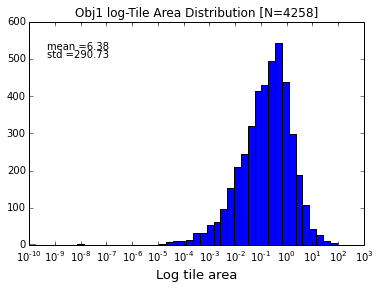

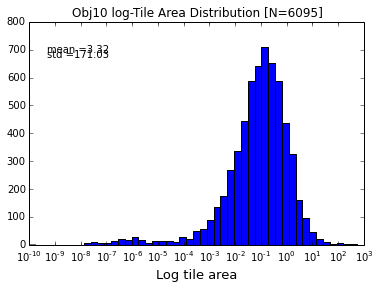

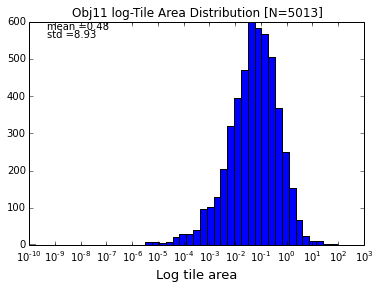

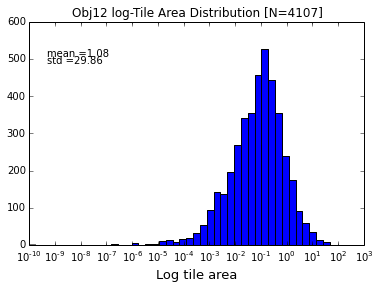

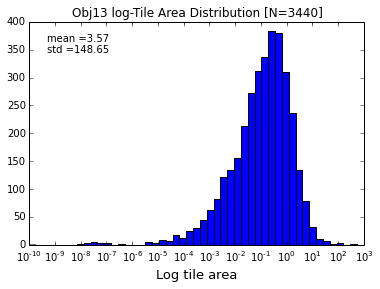

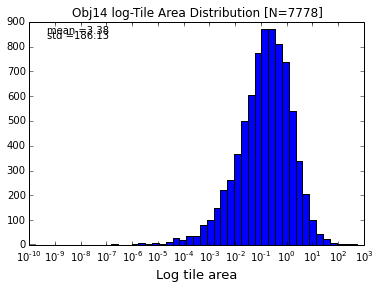

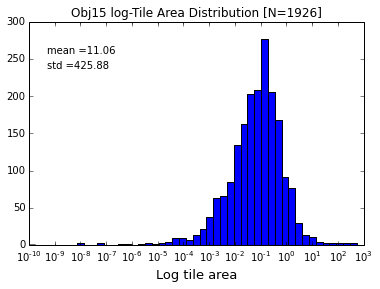

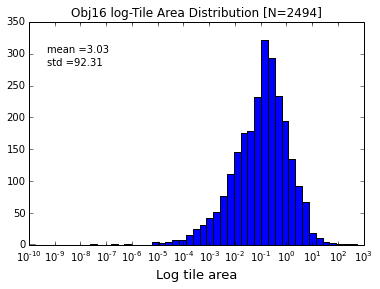

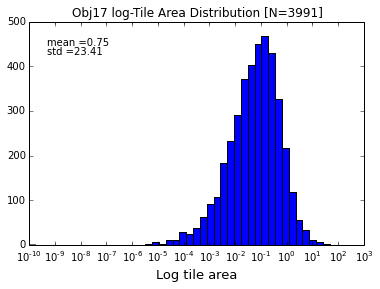

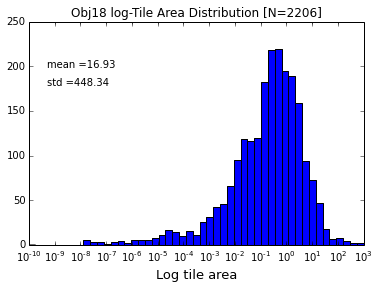

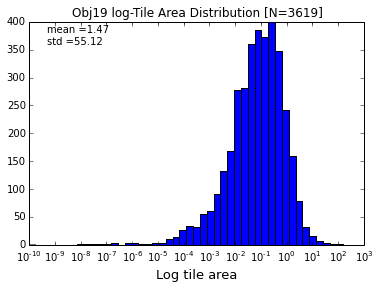

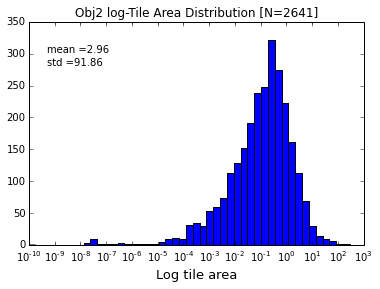

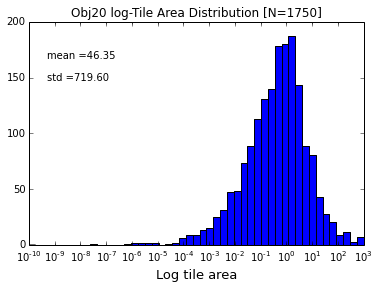

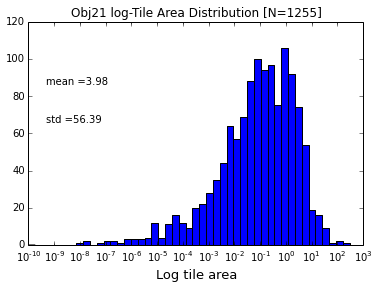

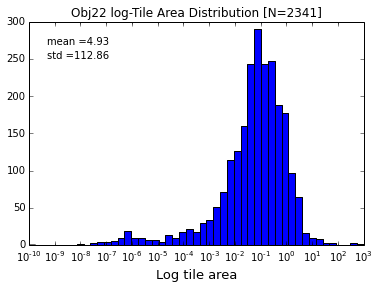

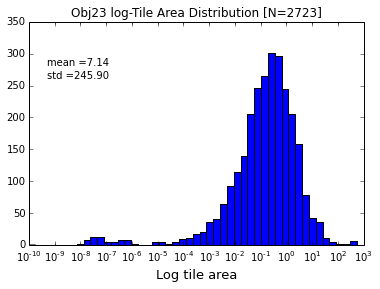

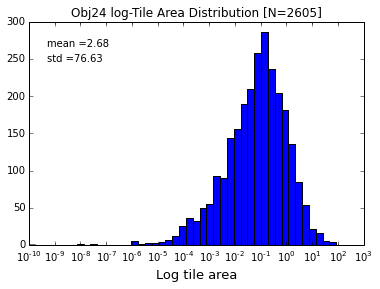

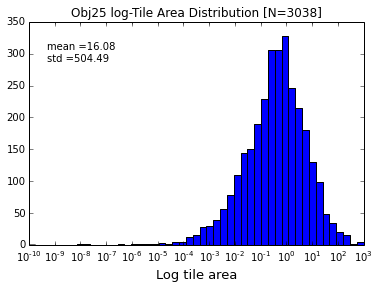

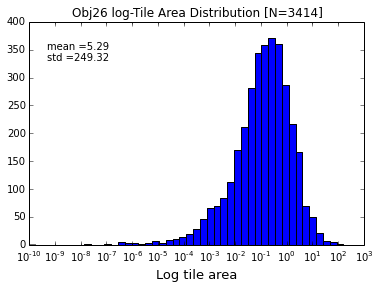

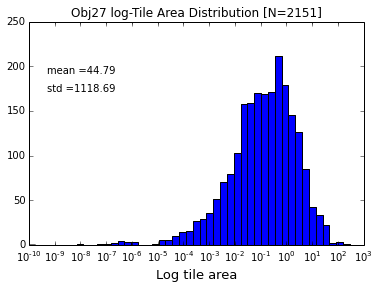

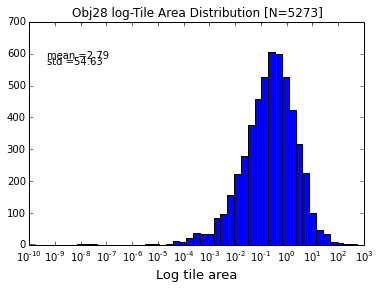

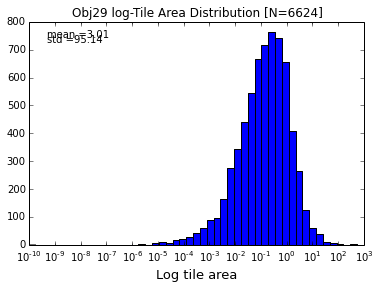

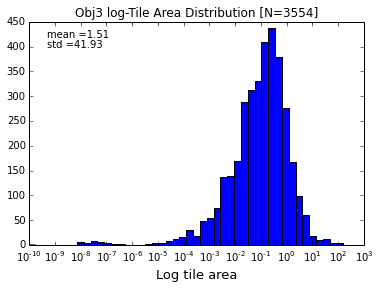

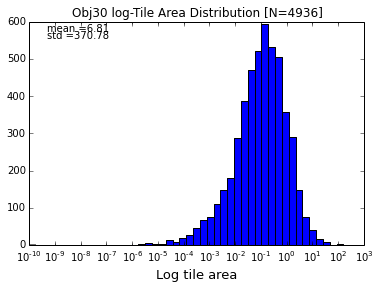

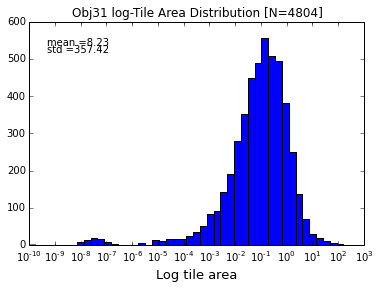

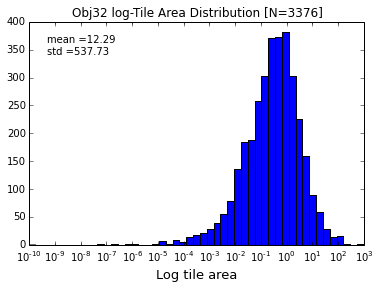

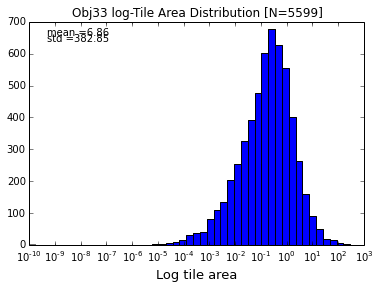

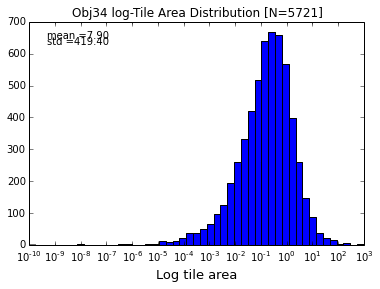

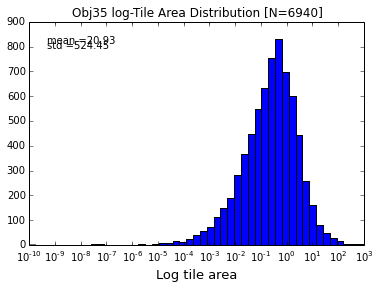

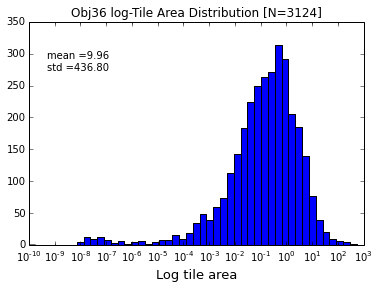

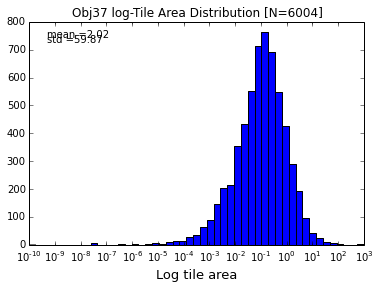

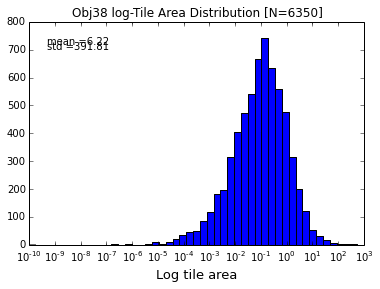

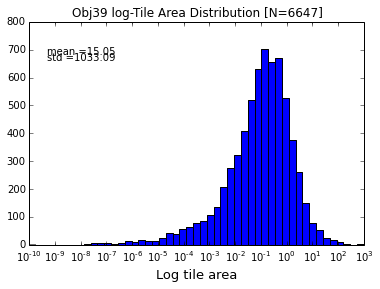

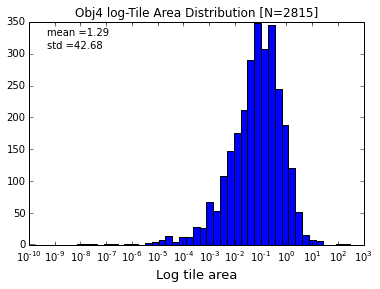

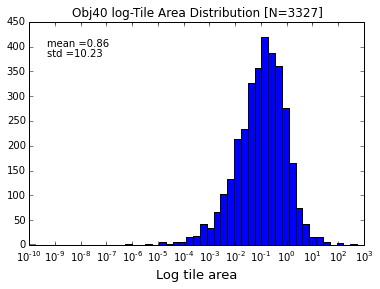

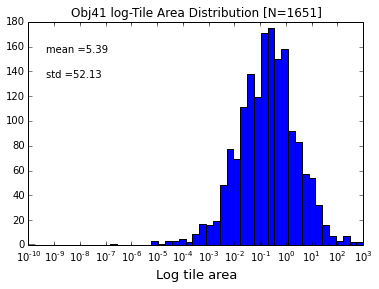

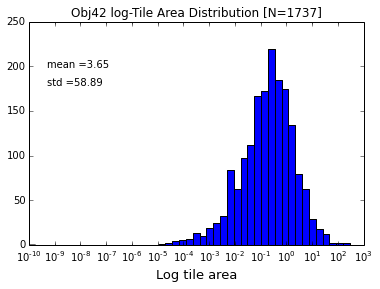

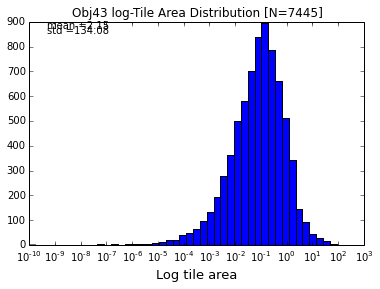

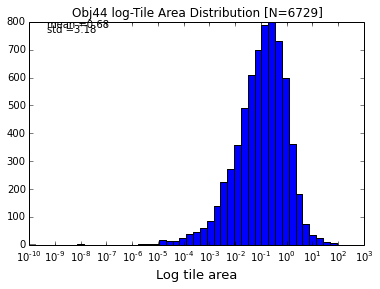

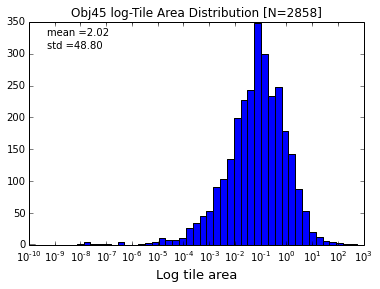

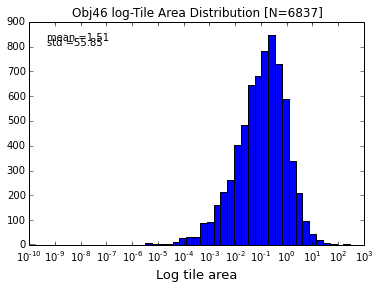

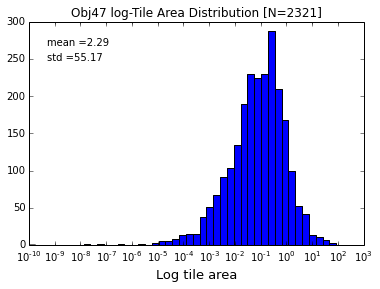

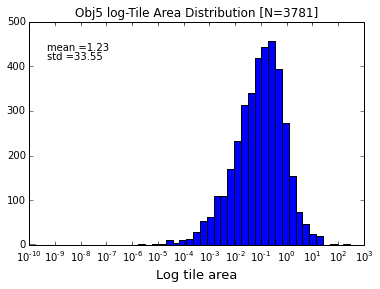

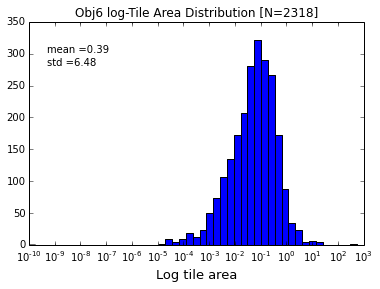

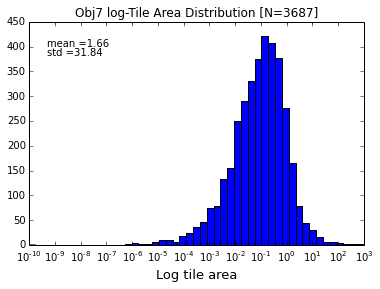

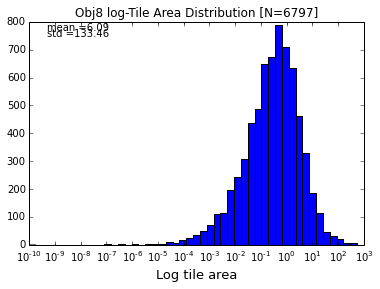

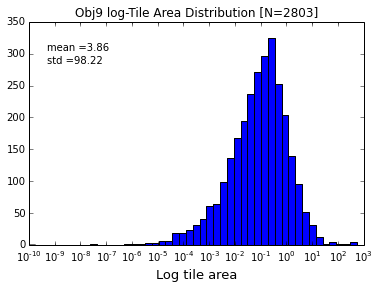

In [11]:
for f in glob("vtiles*.pkl"):
    objid = int(f.split(".")[0][6:])
    tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
    tile_area = [t.area for t in tiles]
    plt.figure()
    hist =plt.hist(tile_area, bins=np.logspace(-10, 3, 50))
    plt.gca().set_xscale("log")
    plt.title("Obj{0} log-Tile Area Distribution [N={1}]".format(objid,len(tile_area)))
    plt.xlabel("Log tile area",fontsize=13)
    plt.text(5e-10,max(hist[0])-20,"mean ={:.2f}".format(mean(tile_area)))
    plt.text(5e-10,max(hist[0])-40,"std ={:.2f}".format(std(tile_area)))

Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True


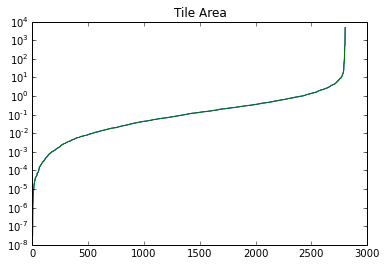

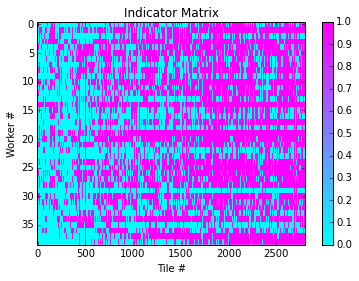

In [12]:
indMat  = pkl.load(open("indMat{}.pkl".format(objid)))
sanity_check(indMat,PLOT=True)

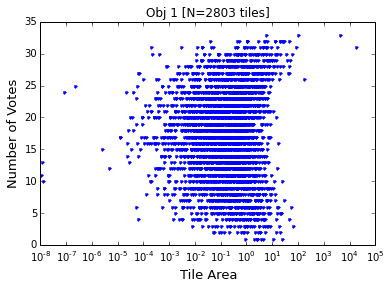

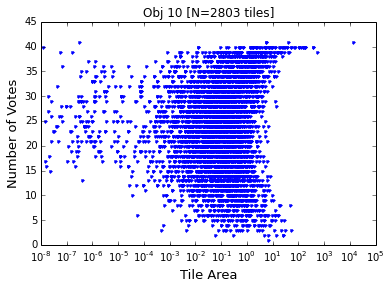

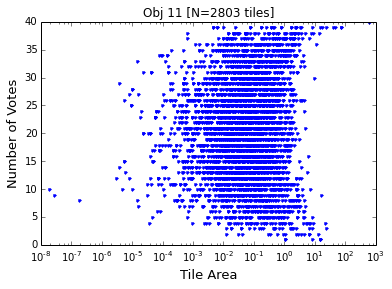

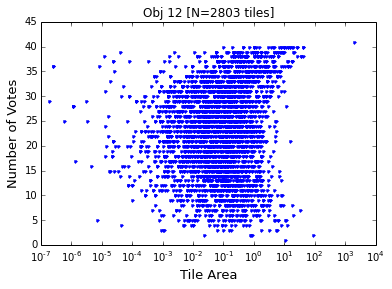

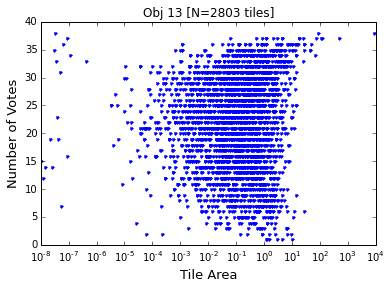

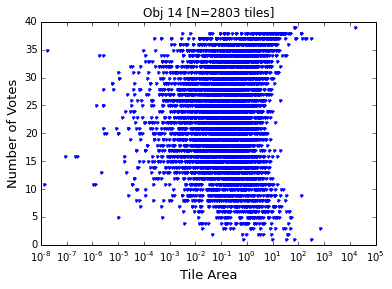

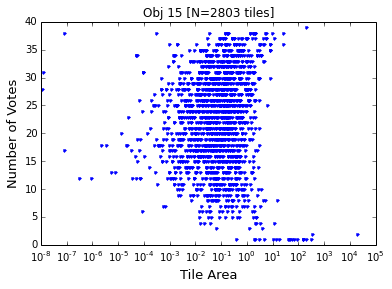

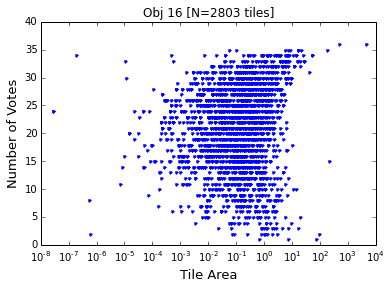

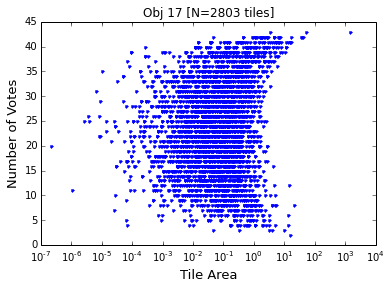

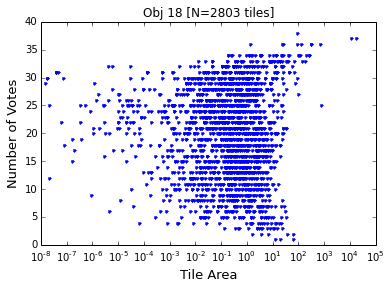

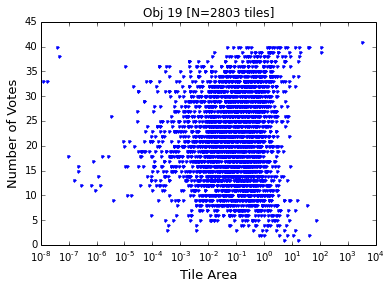

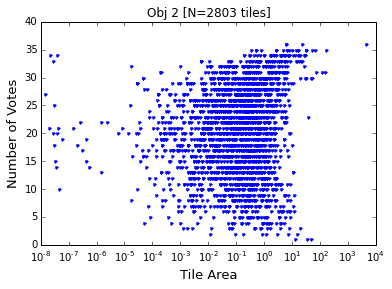

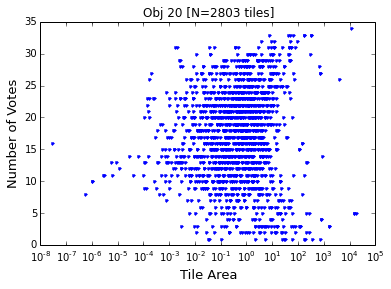

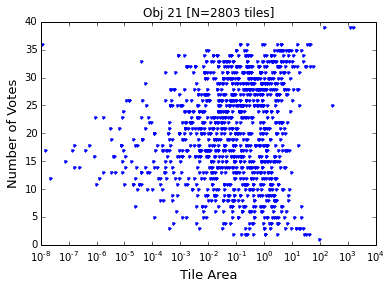

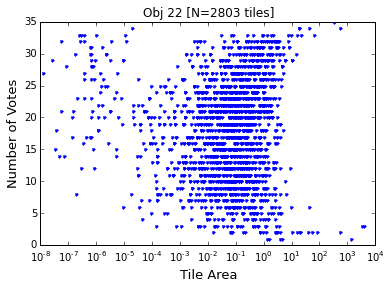

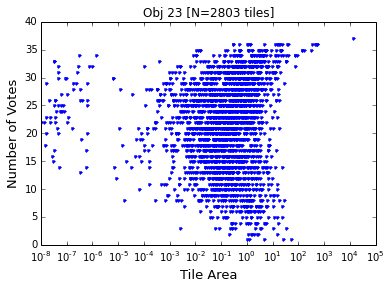

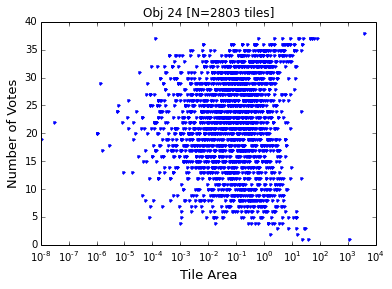

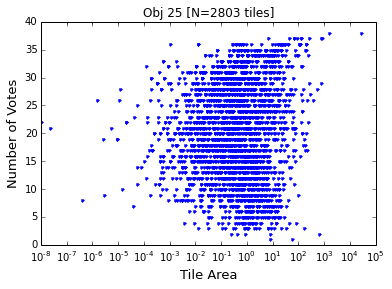

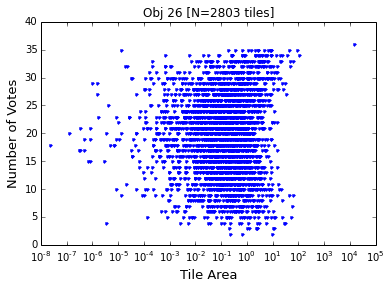

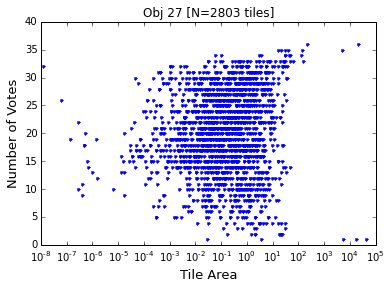

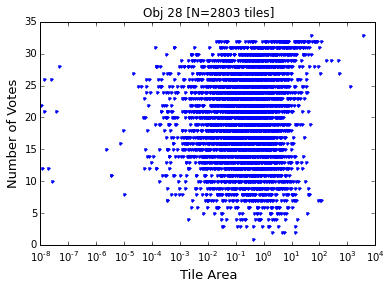

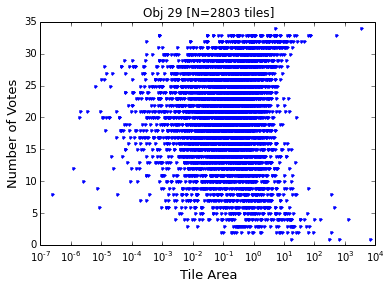

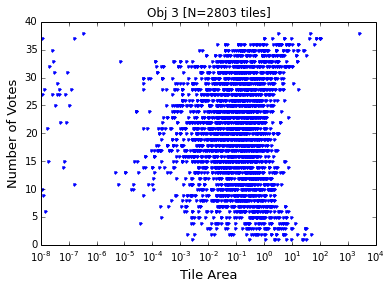

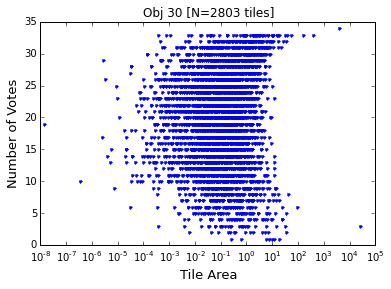

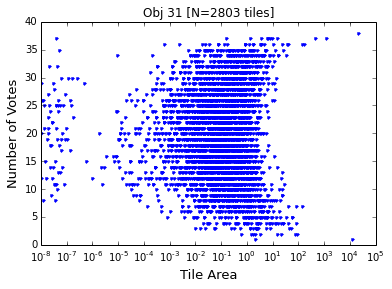

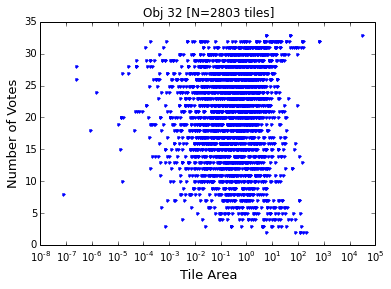

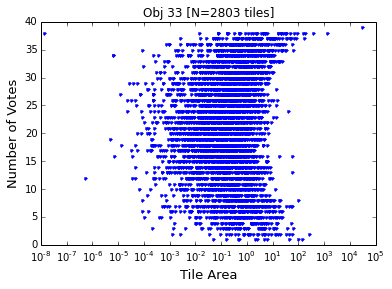

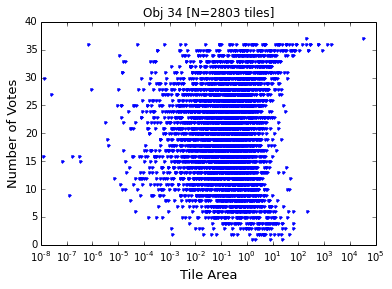

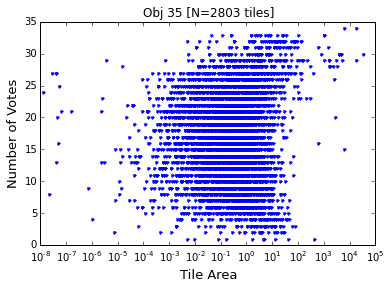

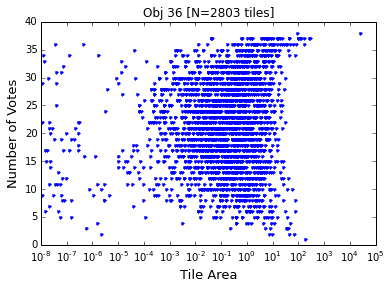

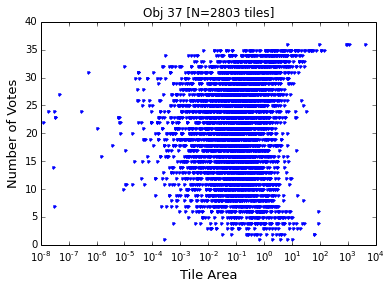

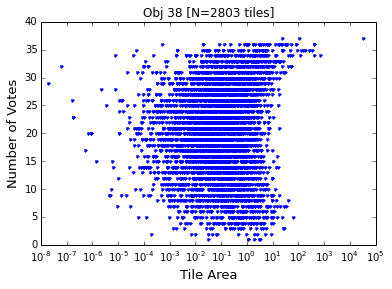

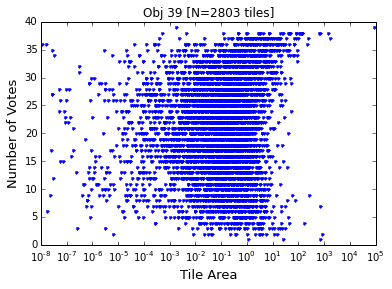

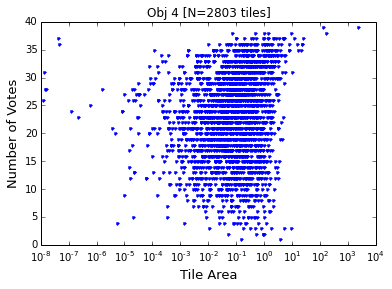

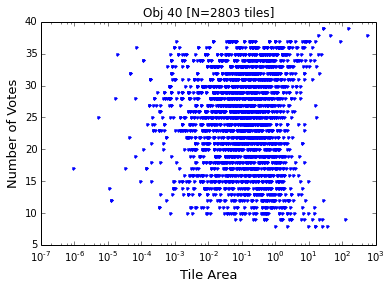

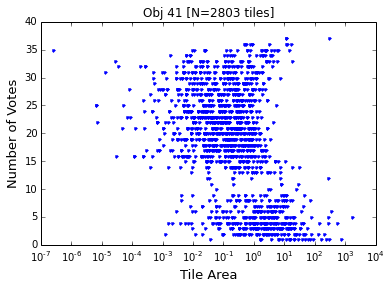

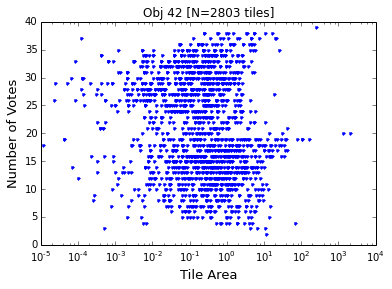

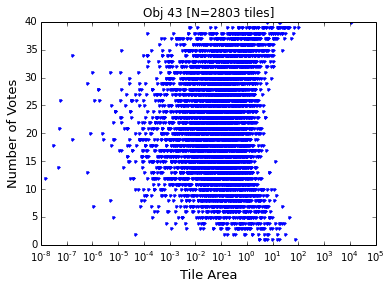

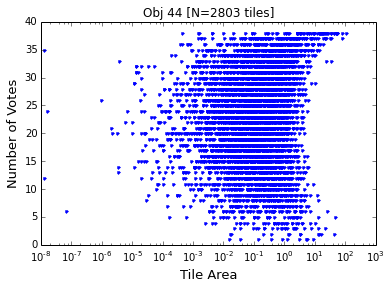

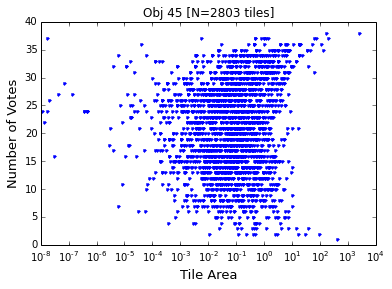

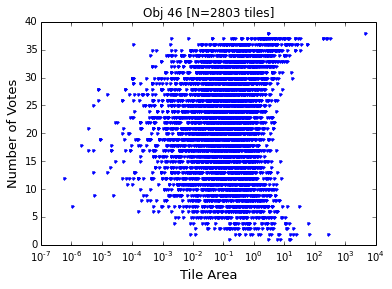

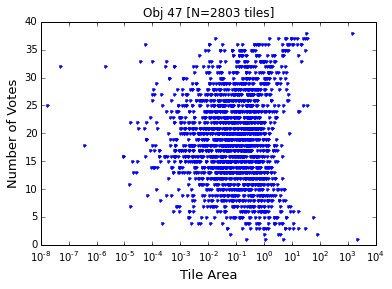

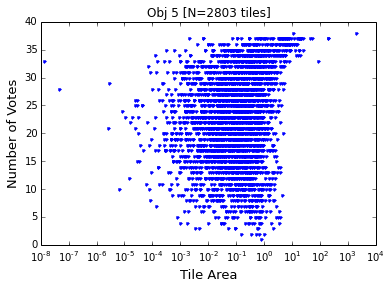

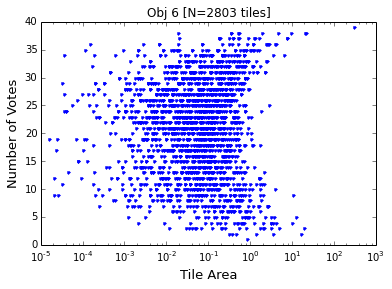

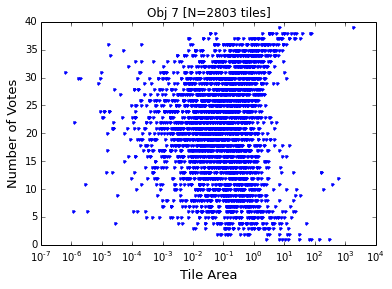

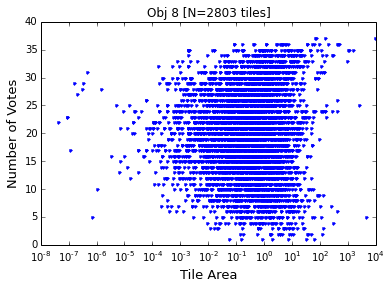

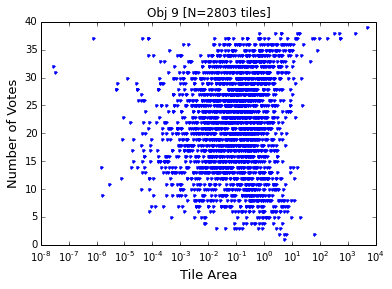

In [13]:
tkArea=[]
tkVotes=[]
for f in glob("vtiles*.pkl"):
    objid = int(f.split(".")[0][6:])
    indMat  = pkl.load(open("indMat{}.pkl".format(objid)))
#     tkVotes.extend(indMat[:-1].sum(axis=0))
#     tkArea.extend(indMat[-1])
    tkVotes=indMat[:-1].sum(axis=0)
    tkArea=indMat[-1]
    plt.figure()
    plt.title("Obj {0} [N={1} tiles]".format(objid,len(tiles)))
    plt.semilogx(tkArea,tkVotes,'.')
    plt.xlabel("Tile Area",fontsize=13)
    plt.ylabel("Number of Votes",fontsize=13)

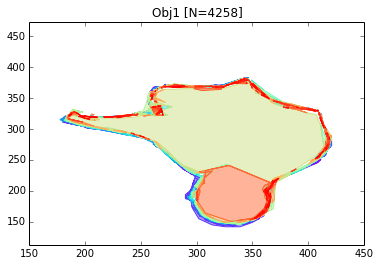

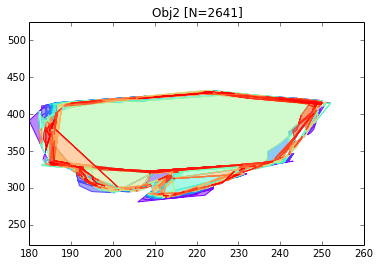

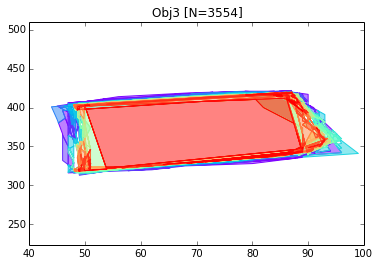

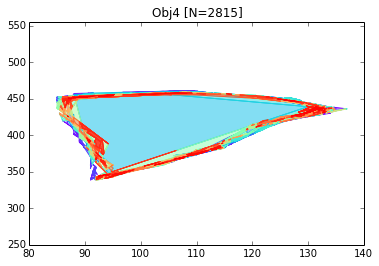

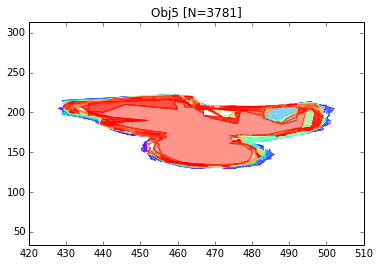

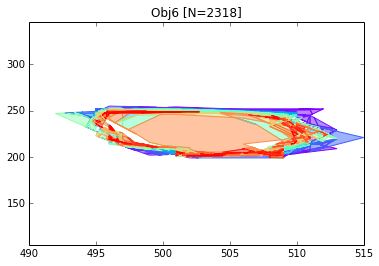

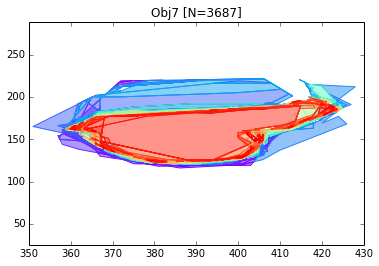

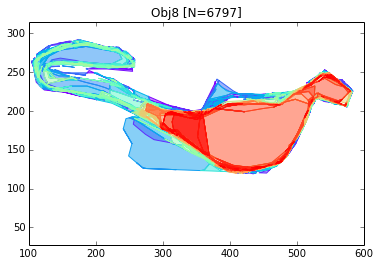

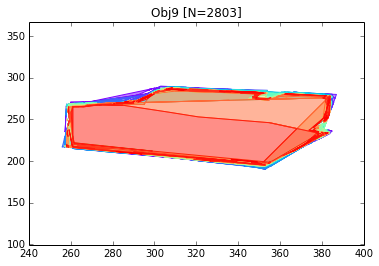

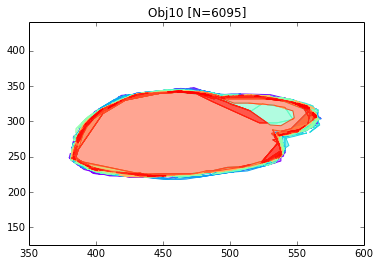

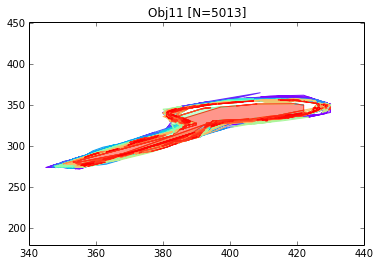

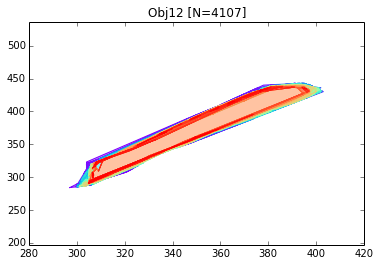

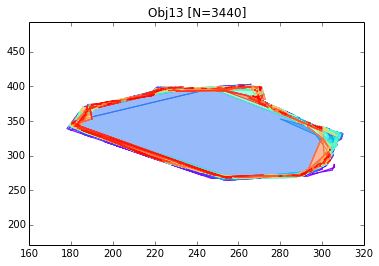

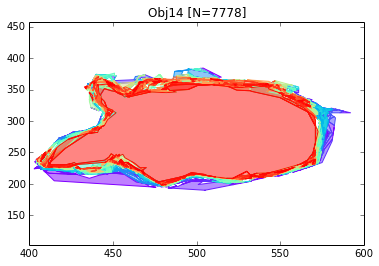

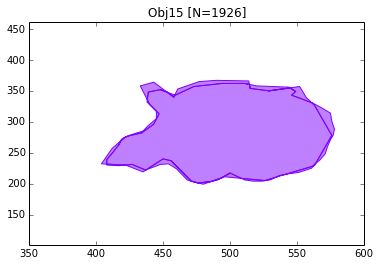

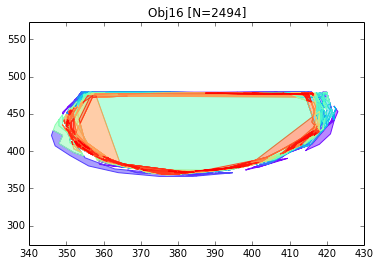

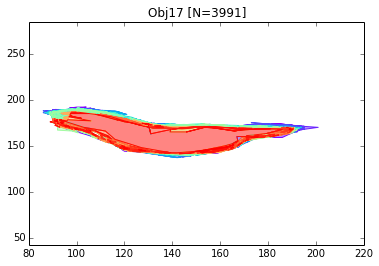

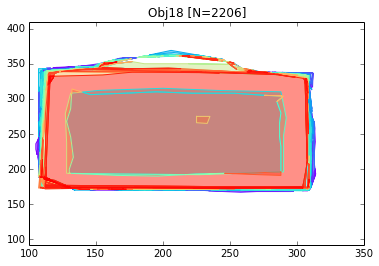

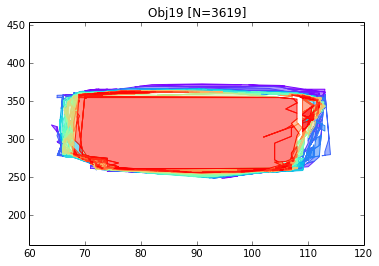

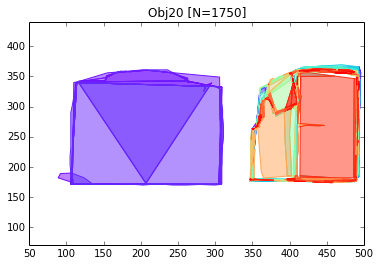

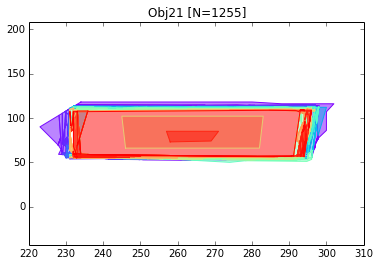

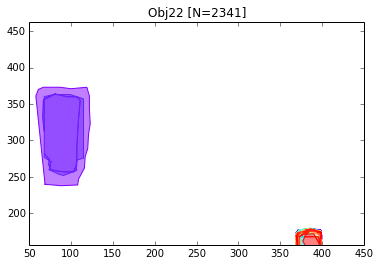

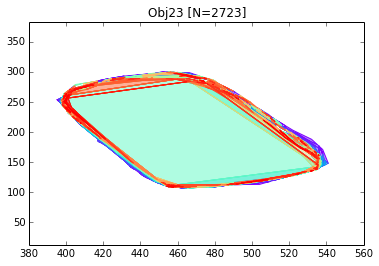

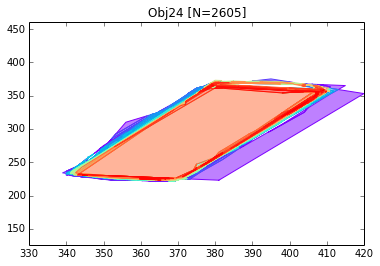

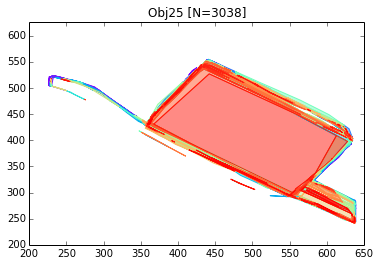

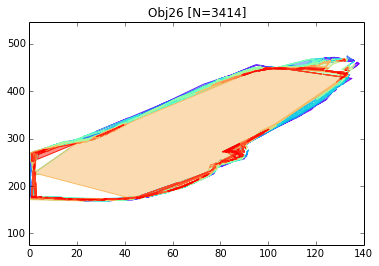

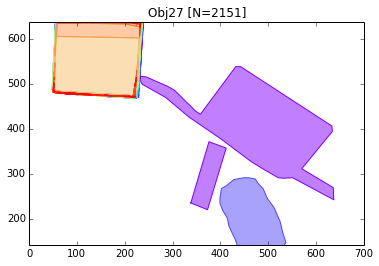

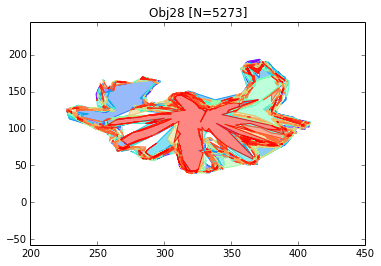

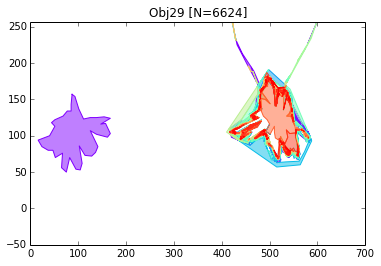

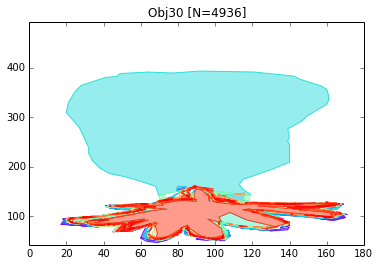

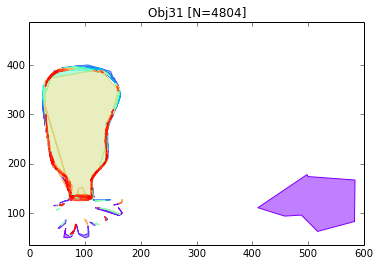

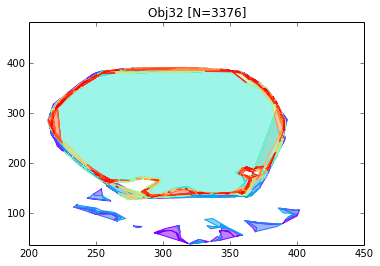

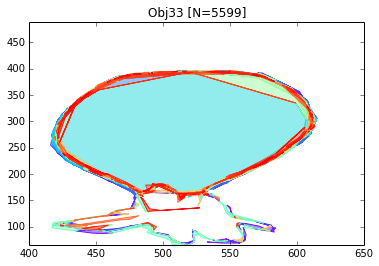

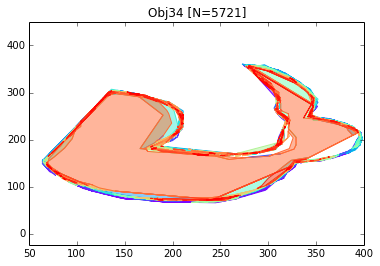

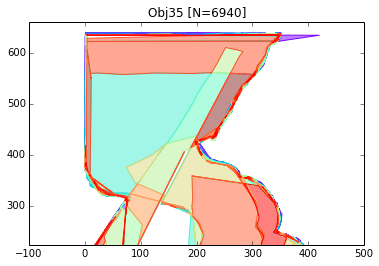

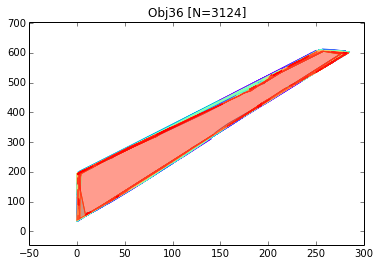

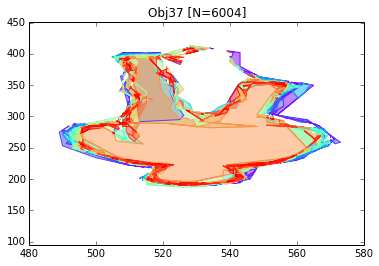

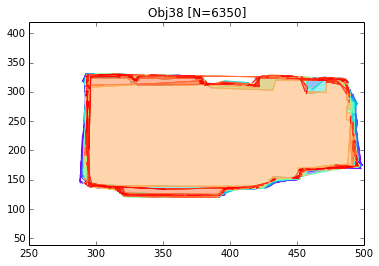

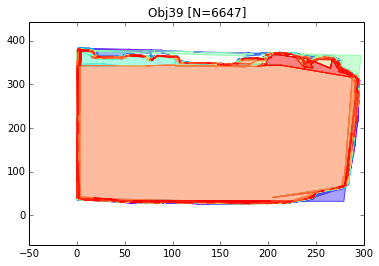

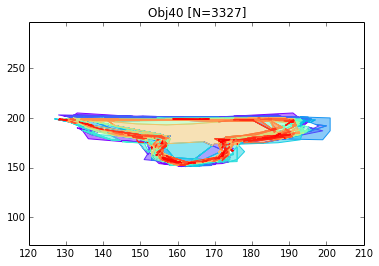

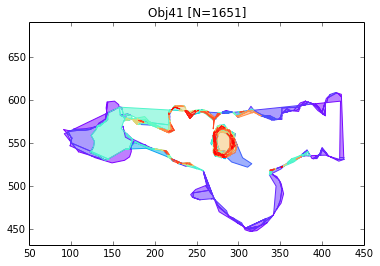

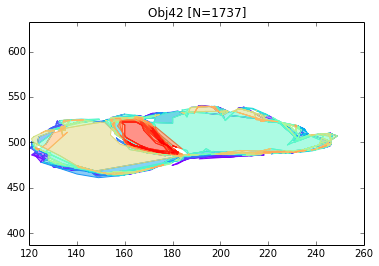

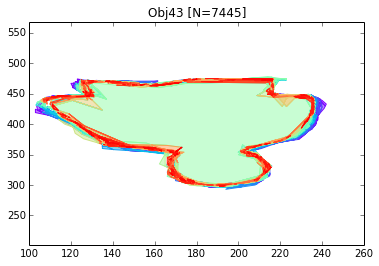

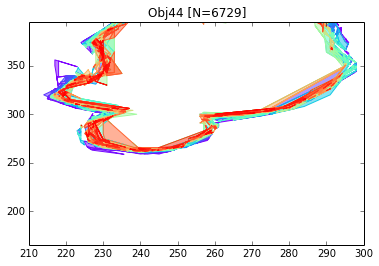

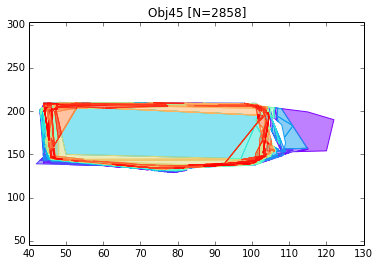

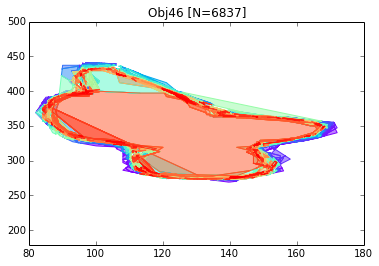

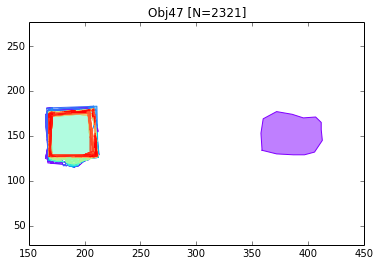

In [14]:
for objid in range(1,48) :
    tiles = pkl.load(open("vtiles{}.pkl".format(objid),'r'))
    visualizeTilesSeparate(tiles)
    plt.title("Obj{0} [N={1}]".format(objid,len(tiles)))
    #xylocs of the largest tile for estimating the obj size
    xlocs,ylocs = tiles[argmax([t.area for t in tiles])].exterior.coords.xy
    plt.ylim(min(ylocs)-100,max(ylocs)+100)
    plt.savefig("Tiles{}.pdf".format(objid))

# Tile 37, 41,44,32,31,29  are missing large central pieces 

In [17]:
objid=44
tiles = pkl.load(open("vtiles{}.pkl".format(objid),'r'))

In [30]:
sum([t.area for t in tiles])

4586.7686753450835

In [27]:
my_BBG  = pd.read_csv("../../my_ground_truth.csv")
ground_truth_match = my_BBG[my_BBG.object_id==objid]
x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
BBG = Polygon(zip(x_locs,y_locs))

In [29]:
BBG.area

9711.0

In [ ]:
def compute_unique_tileset(tiles,PLOT=False):
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        verified_tiles_new= verified_tiles[:]
        for vtidx in range(len(verified_tiles)):
            try:
                vt = verified_tiles[vtidx]
            except(IndexError):
                print "last element removed"
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score, vt.area, t.area
                    duplicated=True
                    if overlap_score<0.99:
                        verified_tiles_new.remove(vt)
                        overlap_region = vt.intersection(t)
                        add_object_to_tiles(verified_tiles_new,overlap_region)
                        add_object_to_tiles(verified_tiles_new,vt.difference(overlap_region))
                        add_object_to_tiles(verified_tiles_new,t.difference(overlap_region))
                        #separate try catch

                    if PLOT: 
                        plt.figure()
                        plt.title("[{0},{1}]{2}".format(tidx,vtidx, overlap_score))

                        try:
                            plot_coords(vt)
                            plot_coords(t,linestyle='--',color="blue")
                            plot_coords(overlap_region,fill_color="lime")
                        except(AttributeError):
                            print "problem with plotting"
            except(shapely.geos.TopologicalError):
                print "Topological Error",tidx,vtidx
        if not duplicated:
            verified_tiles_new.append(t)
        verified_tiles=verified_tiles_new[:]
    return verified_tiles